## Exploratory Data Analysis


### Before creating a classification algorithm, it is essential to understand the dataset better. The distribution of the different labels, image dimensions and color modes will affect how the data preprocessing will be done to ensure that the classifying neural network will receive consistent input.

In [1]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np

The dataset structure is as follows: The root folder contains folders labeled according to different architectural styles. Each of these folders then contains images of buildings representative of the style indicated by the folder name. Now, let's see how many distinct styles we are dealing with:

In [2]:
## Set the path to the dataset
DATA_PATH = 'architectural-styles-dataset'

## Get the list of architectural styles
styles = [folder for folder in os.listdir(DATA_PATH) if not folder.startswith('.')]
print(f"Found {len(styles)} architectural styles: {styles}")

Found 25 architectural styles: ['Palladian architecture', 'Novelty architecture', 'International style', 'Chicago school architecture', 'Beaux-Arts architecture', 'Ancient Egyptian architecture', 'Gothic architecture', 'Tudor Revival architecture', 'Romanesque architecture', 'Colonial architecture', 'American craftsman style', 'Greek Revival architecture', 'Queen Anne architecture', 'Baroque architecture', 'Edwardian architecture', 'Art Nouveau architecture', 'Deconstructivism', 'Bauhaus architecture', 'Georgian architecture', 'Byzantine architecture', 'Postmodern architecture', 'Achaemenid architecture', 'Art Deco architecture', 'American Foursquare architecture', 'Russian Revival architecture']


Alright! We have 25 different architectural styles, spanning from the ancient Achaemenid style to the ultra-modern Deconstructivism. Now we need to know how many images each style folder contains. This is important to know, since class imbalances can affect the performance of a classifier model, and knowing the distribution can help in diagnosing any problems in the accuracy of the model. First, let's create a dictionary with the architectural styles as keys and the respective number of images as values. Then, we can visualize how the numbers are distributed.

In [3]:
style_counts = {}
for style in styles:
    style_counts[style] = len(os.listdir(os.path.join(DATA_PATH, style)))
    
average_images_per_style = sum(style_counts.values()) / len(style_counts)

print(f"Average number of images per style: {int(average_images_per_style)}")

Average number of images per style: 404


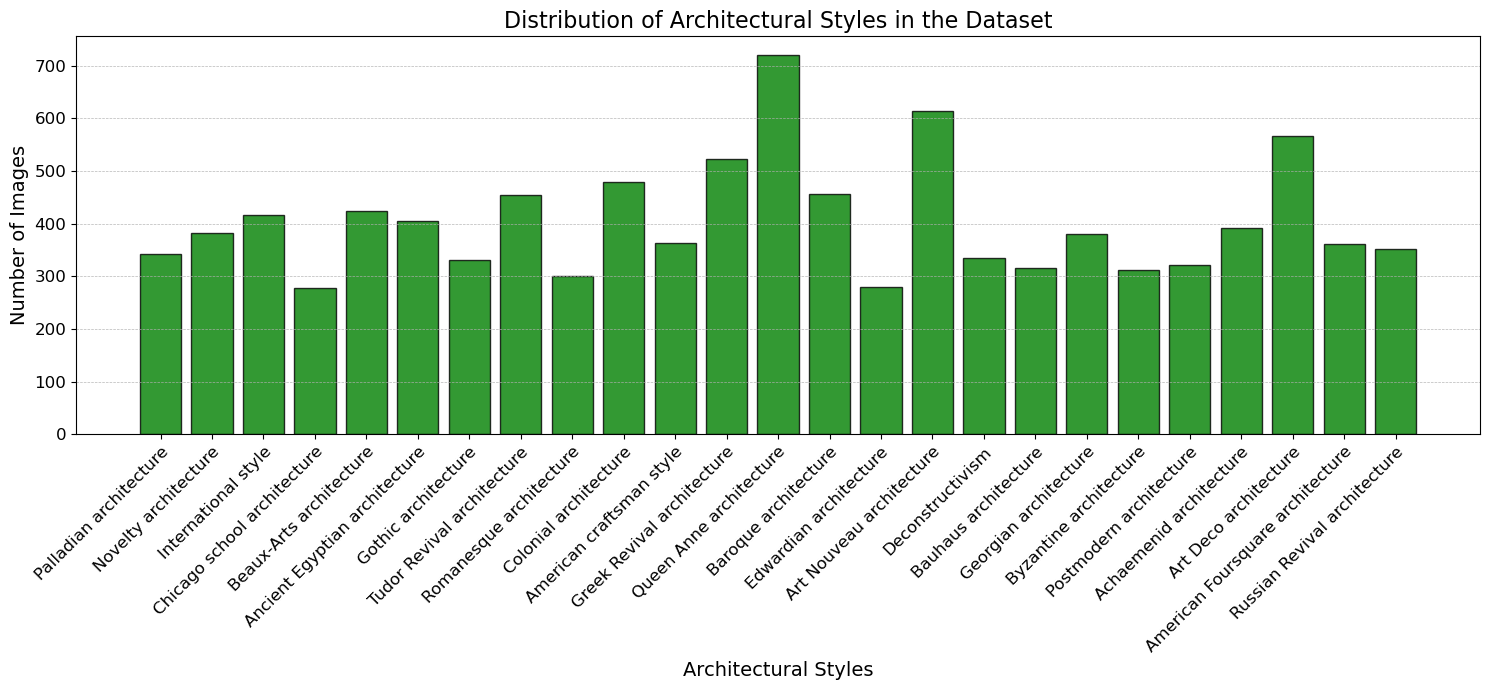

In [4]:
# Set the figure size and color for the bars
plt.figure(figsize=(15, 7))
color = 'green' 

bars = plt.bar(style_counts.keys(), style_counts.values(), color=color, alpha=0.8, edgecolor='black')
plt.xlabel('Architectural Styles', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12, rotation_mode='anchor')
plt.yticks(fontsize=12)
plt.title('Distribution of Architectural Styles in the Dataset', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.9)

# Use tight layout to ensure everything fits
plt.tight_layout()
plt.show()

Great, now we know the distribution of styles within the dataset. This will be helpful during the data augmentation process, which should aim to address the imbalances within the number of samples for each style. Let's move on to figuring out the dimensions (i.e. image heights and widths) as well as the color modes (i.e. the number of channels) present in the images.

In [5]:
# Initialize variables
dimensions = set()
color_types = set()
dimension_distribution = {}

# Analyze images
for style in styles:
    for image_file in os.listdir(os.path.join(DATA_PATH, style)):
        if not image_file.startswith('.'):
            image_path = os.path.join(DATA_PATH, style, image_file)
            with Image.open(image_path) as img:
                dimensions.add(img.size)
                color_types.add(img.mode)
                
                # Distribution of dimensions
                if img.size in dimension_distribution:
                    dimension_distribution[img.size] += 1
                else:
                    dimension_distribution[img.size] = 1

print(f"Unique image dimensions in dataset: {len(dimensions)}")
print(f"Image color modes in dataset: {color_types}")

Unique image dimensions in dataset: 3344
Image color modes in dataset: {'L', 'RGB', 'CMYK'}


As we can see, the image shapes and channels are not standardized at all, and we have a wide variety in our dataset. This makes perfect sense, given the nature of the dataset; some images were scraped from Google Images, others were obtained from Wikimedia. However, this means we will have to preprocess all the images to be RGB. Let's do this now using Pillow the Python Imaging Library.

In [1]:
# Import the Image module from Pillow and os to format our dataset
from PIL import Image
import os

In [2]:
# We don't want to permanently alter our dataset, so let's create a new folder to store these images
input_folder = 'architectural-styles-dataset'
output_folder = 'rgb-dataset'

In [5]:
# Create the output folder 
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    for root, dirs, files in os.walk(input_folder):
        for file_name in files:
            input_path = os.path.join(root, file_name)

            # Determine the relative path within the input folder
            relative_path = os.path.relpath(input_path, input_folder)

            # Create the output subdirectory corresponding to the correct architectural style
            output_subfolder = os.path.join(output_folder, os.path.dirname(relative_path))
            os.makedirs(output_subfolder, exist_ok=True)

            output_path = os.path.join(output_subfolder, file_name)

            # Check if the file is a valid image file
            try:
                img = Image.open(input_path)
            except:
                print(f"Skipping non-image file: {input_path}")
                continue            
                
            if img.mode not in ('RGB'):
                img = img.convert('RGB')  # Convert to RGB

            img.save(output_path)
    print("All files converted to RGB!")


Skipping non-image file: architectural-styles-dataset/.DS_Store
All files converted to RGB!


Now that the images are saved in a folder as RGB files, let's get an idea of the distribution of the dimensions by plotting the height and width distributions using histograms.

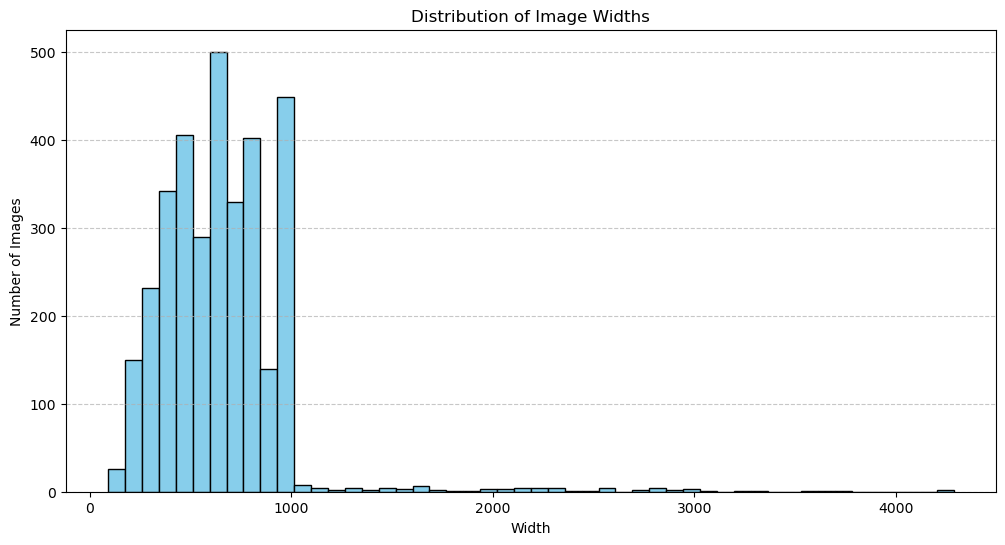

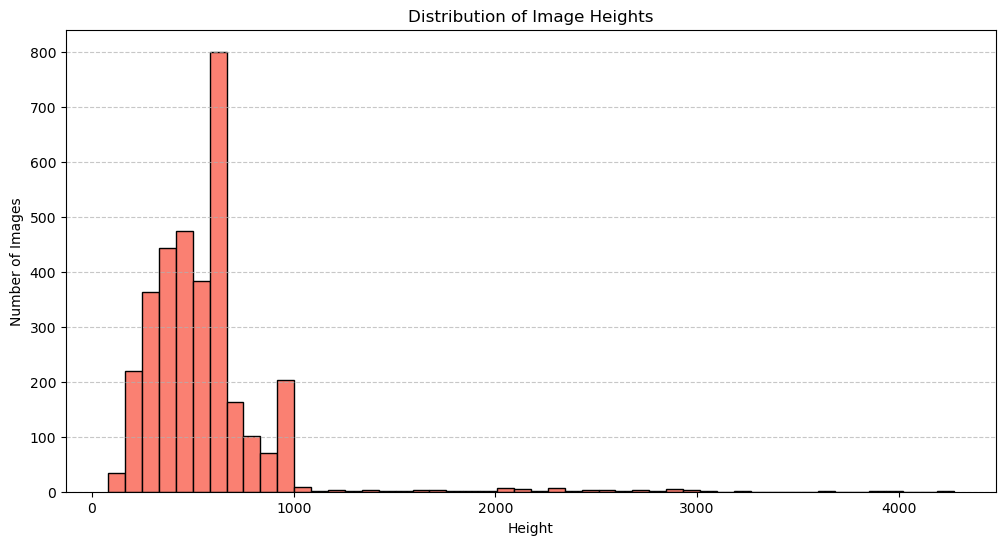

In [6]:
# Separate out widths and heights from the dimensions
widths = [dim[0] for dim in dimensions]
heights = [dim[1] for dim in dimensions]

# Plotting the distribution of widths
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plotting the distribution of heights
plt.figure(figsize=(12, 6))
plt.hist(heights, bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It appears that most images have dimensions smaller than 1000 by 1000 pixels. Also, it seems that the images are not in general square-shaped. Further study could look into these distributions inside each style. For now, we can conclude that we will need a way to resize all the images to a pre-defined square shape, such as 800-by-800 pixels. Luckily, when we build the classification network, pre-built libraries will be able to do the resizing for us.

Finally, let's actually visualize what kind of images we have in the dataset! I will pick nine styles from the dataset at random, and show a random image from each style in a 3-by-3 grid.

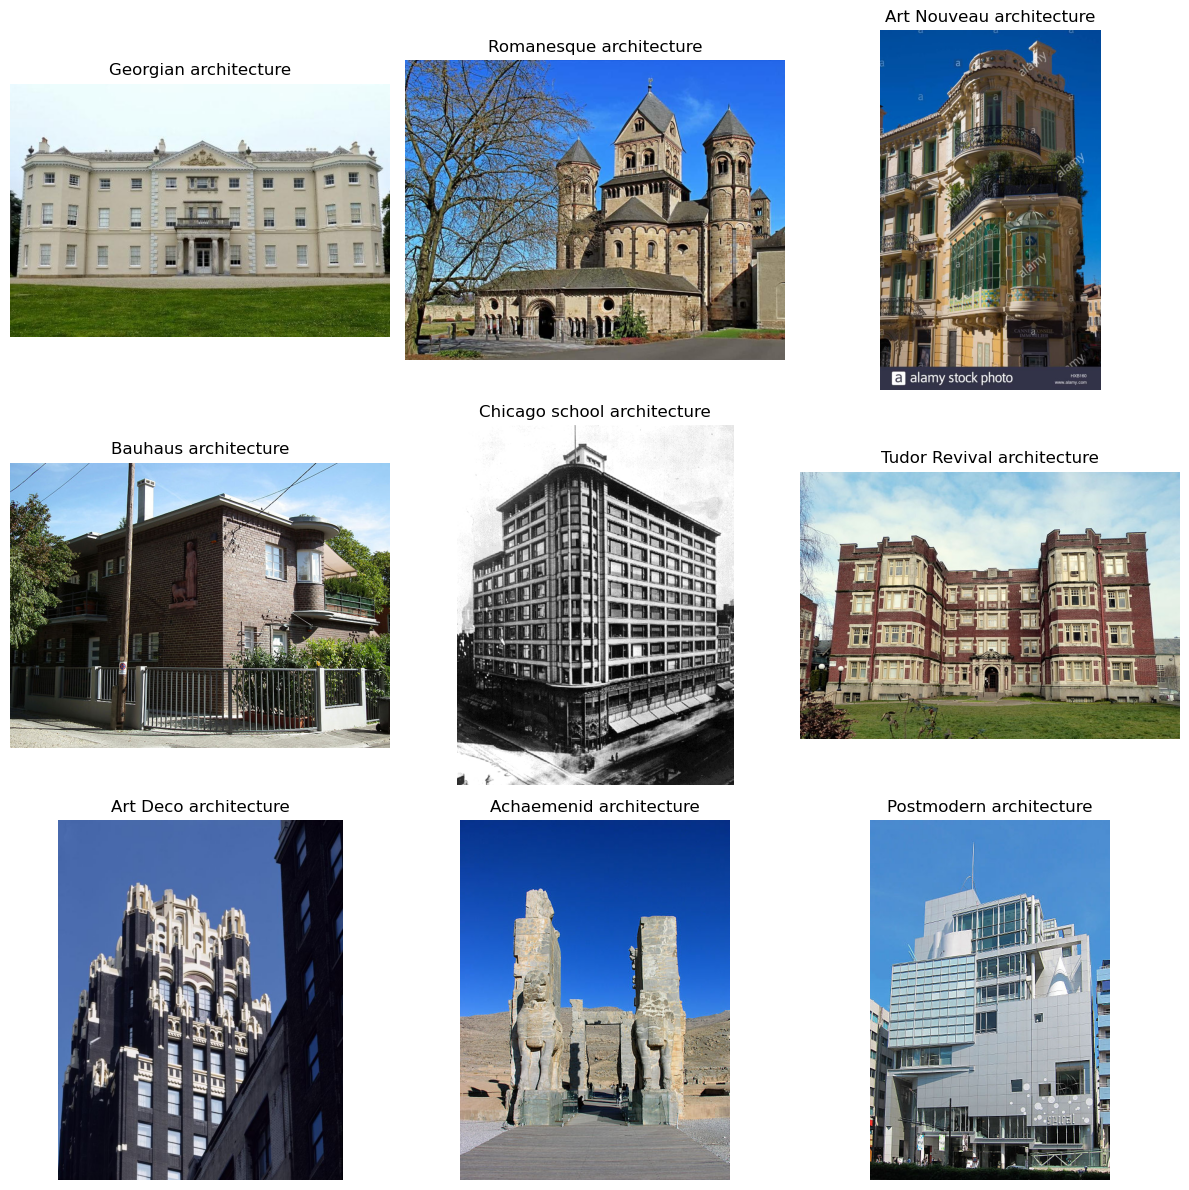

In [7]:
# Randomly select nine styles
selected_styles = np.random.choice(styles, 9, replace=False)

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Iterate over each selected style and display images
for i in range(3):
    for j in range(3):
        style = selected_styles[i*3 + j]
        image_files = [f for f in os.listdir(os.path.join(DATA_PATH, style)) if not f.startswith('.')]
        
        # Sample a single image randomly
        selected_image = np.random.choice(image_files, 1, replace=False)[0]
        
        image_path = os.path.join(DATA_PATH, style, selected_image)
        img = Image.open(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(f"{style}")
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

And there we have it! Clearly the dataset has great variety, with the images taken from many different angles and under different weather and lighting conditions. It will be interesting to see how well we can classify buildings by training a neural network using this dataset!